In [31]:
import MDAnalysis as mda
from MDAnalysis.lib import distances

In [1]:
topology = "../data/gro456.PO4.tpr"
trajectory = "../data/md.PO4.xtc"

### Load system

In [4]:
system = mda.Universe(topology, trajectory)

In [212]:
system.trajectory.next()

< Timestep 3 with unit cell dimensions [659.4375 272.5214 500.      90.      90.      90.    ] >

### Select TO

In [28]:
to = system.select_atoms("resname TO")

In [29]:
%%time
center_of_mass = to.center_of_mass(compound="residues") #Center of mass by residues

CPU times: user 4.95 ms, sys: 4 ms, total: 8.95 ms
Wall time: 7.16 ms


Facteur 10 entre centre de masse de g_aggregate et ceux de MDAnalysis
c_aggregate : 59.639999;17.676666;21.440668

### Distance matrix
With center of mass

In [84]:
dist_matrix = distances.distance_array(center_of_mass, center_of_mass, box = system.dimensions)

### Neighborhood test

In [110]:
neighbors = distances.self_capped_distance(center_of_mass, 13, box = system.dimensions)

In [111]:
neighbors_list = {}
for n in neighbors[0]:
    if n[0] not in neighbors_list:
        neighbors_list[n[0]] = []
    if n[1] not in neighbors_list:
        neighbors_list[n[1]] = []
    neighbors_list[n[0]].append(n[1])
    neighbors_list[n[1]].append(n[0])

### Construct  clusters

In [119]:
def add_to_cluster(cluster, residue, assigned, neighbors_list):
    neighbors = neighbors_list.get(residue,[])
    cluster.add(residue)
    assigned.add(residue)
    for res in neighbors:
        if not res in assigned:
            cluster, assigned = add_to_cluster(cluster, res, assigned, neighbors_list)
        
    return cluster, assigned

In [221]:
%%time
for ts in system.trajectory[:10]:
    to = system.select_atoms("resname TO")
    center_of_mass = to.center_of_mass(compound="residues") #Center of mass by residues
    neighbors = distances.self_capped_distance(center_of_mass, 13, box = system.dimensions)
    neighbors_list = {}
    for n in neighbors[0]:
        if n[0] not in neighbors_list:
            neighbors_list[n[0]] = []
        if n[1] not in neighbors_list:
            neighbors_list[n[1]] = []
        neighbors_list[n[0]].append(n[1])
        neighbors_list[n[1]].append(n[0])
    clusters_array = []
    assigned = set()
    for res in range(to.n_residues):
        if not res in assigned:
            cluster, assigned = add_to_cluster(set(), res, assigned, neighbors_list)
            clusters_array.append(cluster)
    
    sorted_clusters = sorted(clusters_array, key = lambda cluster:len(cluster), reverse = True)
    largest_clusters_atoms = to.residues[list(sorted_clusters[0])].atoms
    largest_com = largest_clusters_atoms.center_of_mass()
    largest_com_C = C_center_of_mass(sorted_clusters[0], center_of_mass)
    print(largest_com)
    print(largest_com_C)

[118.15953644 129.78052918 275.19772421]
[118.10243906879197, 129.74444125610148, 275.19010248874184]
[567.69118066 158.49782126 222.15174924]
[567.6697176713013, 158.23213426456428, 222.15148704837605]
[114.12455717 127.12130979 282.65629704]
[114.07238568923121, 127.13708009368347, 282.68271713753666]
[115.82705026 127.12978672 284.87515172]
[115.76036265635648, 127.08599262360005, 284.8867697548937]
[109.37246744 121.4351614  282.87429451]
[109.30696734508314, 121.42134205009764, 282.903111990956]
[112.60296399 126.92079723 286.24842664]
[112.51740124433717, 126.66122400326628, 286.28802832294446]
[109.16747133 124.40052371 285.76522198]
[109.07478909350583, 124.47741401517942, 285.8197719376879]
[115.067934   123.42052647 284.50119329]
[115.00084747254158, 123.58789777305861, 284.55436589333164]
[115.89978014 123.30322197 286.47955875]
[115.84063132580361, 123.28816673930531, 286.522823891439]
[112.09668218 124.20702433 289.92896683]
[112.03429913895134, 124.14347399884795, 289.997

In [196]:
to.residues[[0,1]].atoms

<AtomGroup with 30 atoms>

In [218]:
import math
def C_center_of_mass(cluster, residues_com):
    aaCM= [0,0,0,0,0,0]
    Lx = system.dimensions[0]
    Ly = system.dimensions[1]
    Lz = system.dimensions[2]
    for res in cluster:
        aaCM[0] += math.cos(2 * math.pi * residues_com[res][0] / Lx)/len(cluster)
        aaCM[1] += math.sin(2 * math.pi * residues_com[res][0] / Lx)/len(cluster)
        aaCM[2] += math.cos(2 * math.pi * residues_com[res][1] / Ly)/len(cluster)
        aaCM[3] += math.sin(2 * math.pi * residues_com[res][1] / Ly)/len(cluster)
        aaCM[4] += math.cos(2 * math.pi * residues_com[res][2] / Lz)/len(cluster)
        aaCM[5] += math.sin(2 * math.pi * residues_com[res][2] / Lz)/len(cluster)
        
    
    com_x = (math.atan2(-aaCM[1], -aaCM[0]) + math.pi) * Lx / (2*math.pi)
    com_y = (math.atan2(-aaCM[3], -aaCM[2]) + math.pi) * Ly / (2*math.pi)
    com_z = (math.atan2(-aaCM[5], -aaCM[4]) + math.pi) * Lz / (2*math.pi)
                                                                         
    return [com_x, com_y, com_z]

### Clustering
recursiv_clust method in C code

In [126]:
def recursiv_it(distmat, threshold, nb_residues, actual_residue, actual_cluster, clusters, nb_clusters):
    clusters[actual_residue] = actual_cluster
    for i in range(nb_residues):
        if distmat[actual_residue][i] < threshold and i != actual_residue and i not in clusters : 
            if actual_cluster == 0:
                nb_clusters += 1 
                actual_cluster = nb_clusters
                clusters[actual_residue] = actual_cluster
            clusters, nb_clusters = recursiv_it(distmat, threshold, nb_residues, i, actual_cluster, clusters, nb_clusters)
    return clusters, nb_clusters

def recursiv_clust(distmat, threshold, nb_residues):
    nb_clusters = 0
    clusters = {}
    
    for i in range(nb_residues):
        if not i in clusters:
            clusters, nb_clusters = recursiv_it(distmat, threshold, nb_residues, i, 0, clusters, nb_clusters)
    
    return clusters, nb_clusters

In [218]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [103]:
%time
clusters, nb_clusters = recursiv_clust(dist_matrix, 13, to.n_residues)

CPU times: user 8 µs, sys: 2 µs, total: 10 µs
Wall time: 19.8 µs


The cluster 0 is the list of alone molecules. 

In [127]:
nb_clusters = 0
clusters = {}
clusters_key = {}
for mol in clusters:
    cluster = clusters[mol]
    if cluster not in clusters_key:
        clusters_key[cluster] = []
    clusters_key[cluster].append(mol)

nb_cluster = len(clusters_key)
for mol in clusters_key[0]:
    clusters_key[nb_cluster] = [mol]
    nb_cluster += 1
del clusters_key[0]

KeyError: 0

In [105]:
print(len(clusters_key))

232


In [107]:
print(clusters_key[1])

[0, 467, 424, 517, 336, 603, 613]


In [222]:
clusters_size = {}
for k in clusters_key:
    length = len(clusters_key[k])
    if not length in clusters_size : 
        clusters_size[length] = 0
    clusters_size[length] += 1
print(clusters_size)

{186: 1, 190: 1, 2: 25, 4: 2, 3: 6, 5: 1, 1: 193}


In [223]:
average = sum([len(clusters_key[k]) for k in clusters_key]) / len(clusters_key)
print(average)

2.8384279475982535


In [25]:
%%time
dist_matrix = constructMatrix(nb_residues, to)

CPU times: user 1.94 s, sys: 2.3 ms, total: 1.94 s
Wall time: 1.94 s


In [26]:
%%time
dist_matrix = constructMatrix(nb_residues, to)

CPU times: user 1.89 s, sys: 6.12 ms, total: 1.9 s
Wall time: 1.9 s


In [137]:
print(dist_matrix[0][1])

456.3382464313222


In [132]:
%lprun -f constructMatrix constructMatrix(nb_residues, to)

In [142]:
%%time
for ts in system.trajectory[:5]:
    dist_matrix = constructMatrix(nb_residues, to)
    

CPU times: user 9.33 s, sys: 0 ns, total: 9.33 s
Wall time: 9.32 s


In [137]:
%%time
for ts in system.trajectory[:1]:
    to = system.select_atoms("resname TO")
    center_of_mass = to.center_of_mass(compound="residues") #Center of mass by residues
    dist_matrix = distances.distance_array(center_of_mass, center_of_mass, box = system.dimensions)
    clusters, nb_clusters = recursiv_clust(dist_matrix, 13, to.n_residues)

CPU times: user 274 ms, sys: 4.11 ms, total: 279 ms
Wall time: 276 ms


In [238]:
%lprun -f recursiv_clust recursiv_clust(dist_matrix, 13, to.n_residues)

In [246]:
for res in to.residues:
    print(res)
    res.center_of_mass = "test"
    break

<Residue TO, 2016>


AttributeError: Cannot set arbitrary attributes to a Component

### Test networkx 

In [133]:
import networkx as nx

In [139]:
%%time
for ts in system.trajectory[:1]:
    to = system.select_atoms("resname TO")
    center_of_mass = to.center_of_mass(compound="residues") #Center of mass by residues
    dist_matrix = distances.distance_array(center_of_mass, center_of_mass, box = system.dimensions)
    graph = nx.from_numpy_matrix(dist_matrix)

CPU times: user 1.05 s, sys: 24 ms, total: 1.07 s
Wall time: 1.07 s


In [2]:
import plotly.express as px

In [4]:
df = px.data.iris()
print(df)

     sepal_length  sepal_width  petal_length  petal_width    species  \
0             5.1          3.5           1.4          0.2     setosa   
1             4.9          3.0           1.4          0.2     setosa   
2             4.7          3.2           1.3          0.2     setosa   
3             4.6          3.1           1.5          0.2     setosa   
4             5.0          3.6           1.4          0.2     setosa   
..            ...          ...           ...          ...        ...   
145           6.7          3.0           5.2          2.3  virginica   
146           6.3          2.5           5.0          1.9  virginica   
147           6.5          3.0           5.2          2.0  virginica   
148           6.2          3.4           5.4          2.3  virginica   
149           5.9          3.0           5.1          1.8  virginica   

     species_id  
0             1  
1             1  
2             1  
3             1  
4             1  
..          ...  
145      

In [8]:
import seaborn as sns
tips = sns.load_dataset("tips")

In [10]:
print(type(tips))

<class 'pandas.core.frame.DataFrame'>


In [12]:
{"a":[]}.add{"b":0}

SyntaxError: invalid syntax (<ipython-input-12-8725ee24dce4>, line 1)

In [13]:
results = {'time': [0.0, 1000.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0], 'cluster1_size': [188, 190, 193, 190, 193, 200, 190, 189, 184, 185], 'cluster2_size': [163, 190, 190, 186, 165, 187, 188, 177, 178, 181], 'cluster3_size': [7, 5, 5, 5, 6, 8, 5, 4, 6, 9]}

In [14]:
import matplotlib.pyplot as plt

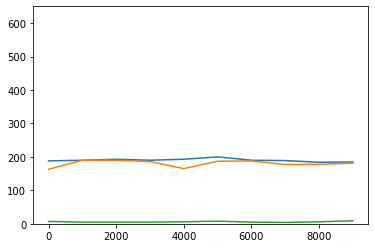

In [19]:
plt.plot(results["time"], results["cluster1_size"])
plt.ylim(0, 650)
plt.plot(results["time"], results["cluster2_size"])
plt.plot(results["time"], results["cluster3_size"])